# QuickDraw CNN with Tensorflow 2.0

To start this notebook you need to download the following files. <br>

    - full_numpy_bitmap_airplane.npy
    - full_numpy_bitmap_book.npy
    - full_numpy_bitmap_car.npy
    - full_numpy_bitmap_dog.npy
    - full_numpy_bitmap_face.npy
    - full_numpy_bitmap_apple.npy
    - full_numpy_bitmap_brain.npy
    - full_numpy_bitmap_chair.npy
    - full_numpy_bitmap_eye.npy
    - full_numpy_bitmap_The Eiffel Tower.npy

Then you need to store the file in a folder named: <b>quick_draw_dataset</b>

[Download the files here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1)

# Dependencies

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split #pip install sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


## Be sure to used Tensorflow 2.0

In [9]:
assert hasattr(tf, "function") # Be sure to use tensorflow 2.0

# Load the dataset

In [10]:
dataset_dir = "quick_draw_dataset"
files = os.listdir(dataset_dir)
max_size_per_cl = 1500
draw_class = []

# Evalueate the size of the dataset
size = 0
for name in files:
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    size += draws.shape[0]

images = np.zeros((size, 28, 28))
targets = np.zeros((size,))

it = 0
t = 0
for name in files:
    # Open each dataset and add the new class
    draw_class.append(name.replace("full_numpy_bitmap_", "").replace(".npy", ""))
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    # Add images to the buffer
    images[it:it+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
    targets[it:it+draws.shape[0]] = t
    # Iter
    it += draws.shape[0]
    t += 1

# Shuffle dataset
indexes = np.arange(size)
np.random.shuffle(indexes)
images = images[indexes]
targets = targets[indexes]

images, images_valid, targets, targets_valid = train_test_split(images, targets, test_size=0.33)

print("images.shape", images.shape)
print("targets.shape", targets.shape)

print("images_valid.shape", images_valid.shape)
print("targets_valid.shape", targets_valid.shape)

print(draw_class)

images.shape (10050, 28, 28)
targets.shape (10050,)
images_valid.shape (4950, 28, 28)
targets_valid.shape (4950,)
['face', 'brain', 'The Eiffel Tower', 'chair', 'eye', 'airplane', 'apple', 'car', 'book', 'dog']


## Plot exemples of images

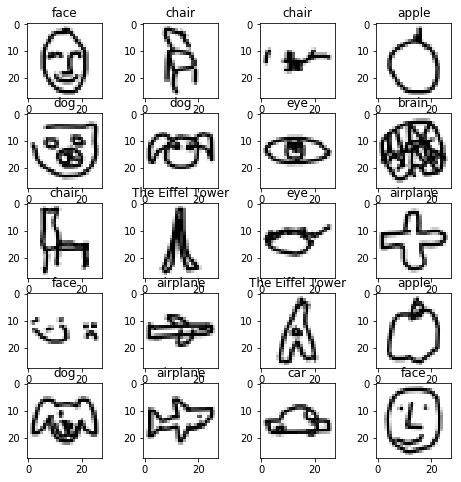

In [11]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    index = np.random.randint(len(images))
    img = images[index]
    fig.add_subplot(rows, columns, i)
    plt.title(draw_class[int(targets[index])]) 
    plt.imshow(img, cmap="gray")
plt.show()

## Normalization

In [12]:
print("Mean and std of images", images.mean(), images.std())
scaler = StandardScaler()
scaled_images = scaler.fit_transform(images.reshape(-1, 28*28))
scaled_images_valid = scaler.fit_transform(images_valid.reshape(-1, 28*28))
print("Mean and std of scaled images", scaled_images.mean(), scaled_images.std())

scaled_images = scaled_images.reshape(-1, 28, 28, 1)
scaled_images_valid = scaled_images_valid.reshape(-1, 28, 28, 1)

Mean and std of images 209.56681769722815 85.14788918316974
Mean and std of scaled images -1.4596101766573608e-16 0.9285714285714276


## Handle dataset
### Create the dataset

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(scaled_images)
valid_dataset = tf.data.Dataset.from_tensor_slices(scaled_images_valid)

### Iter in dataset

In [14]:
for item in train_dataset:
    print(item.shape)
    break

(28, 28, 1)


In [15]:
# Iter in the dataset with a number of epoch and batch size
epoch = 1
batch_size = 32
for batch_training in train_dataset.repeat(epoch).batch(32):
    print(batch_training.shape)
    break

(32, 28, 28, 1)


### Create the training dataset

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images, targets))
valid_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_valid, targets_valid))

In [17]:
# Iter in the dataset with a number of epoch and batch size
epoch = 1
batch_size = 32
for images_batch, targets_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(images_batch.shape, targets_batch.shape)
    break

(32, 28, 28, 1) (32,)


# Build a model with the subclassing API

In [18]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation='relu', name="conv1")
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', name="conv2")
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', name="conv3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(10, activation='softmax', name="output")

    def call(self, image):
        conv1 = self.conv1(image)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        flatten = self.flatten(conv3)
        d1 = self.d1(flatten)
        output = self.out(d1)
        return output

model = ConvModel()

## Set the loss and objectives

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

## Set some metrics to track the progress of the training

In [20]:
# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

## Training method
The train_step method used autograp, compute the gradient to optimize the model and gather the loss and accuracy on the training set

In [21]:
@tf.function
def train_step(image, targets):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(image)
        # Get the error/loss on these predictions
        loss = loss_object(targets, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(targets, predictions)

## Validation method
The valid_step function is simply used to test the image on the validation set and to gather the loss and accuracy

In [22]:
@tf.function
def valid_step(image, targets):
    predictions = model(image)
    t_loss = loss_object(targets, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)

# Train and test the model on the validation set

In [ ]:
epoch = 10
batch_size = 32
b = 0
for epoch in range(epoch):
    # Training set
    for images_batch, targets_batch in train_dataset.batch(batch_size):
        train_step(images_batch, targets_batch)
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(targets), train_loss.result(), 
            train_accuracy.result()*100
        ), end="")
        b += batch_size
    # Validation set
    for images_batch, targets_batch in valid_dataset.batch(batch_size):
        valid_step(images_batch, targets_batch)

    template = 'Epoch {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )